# Jupyter Notebook
---

>"an open-source web application that allows you to create and share documents that contain **live code**, equations, visualizations and **explanatory text**"

This talk is (_ostensibly_) about lexical scope in Ruby; secretly, it has the ulterior motive of illustrating how Jupyter Notebook can be used to create a presentation.

Let's get into it!

## Lexical Scope
---

>"Lexical scope?"
> > -- some guy

_Lexical scope_ is all about name resolution in programs, essentially answering "when do I bother checking on what `foo` actually is?"

It's closely related to _closures_, so we will look at both, but first, lets take  more specific look at what lexical scope means:


**Lexical**
/ˈleksək(ə)l/

_adjective_

1. Relating to the words or vocabulary of a language.    
    1.1 Relating to or of the nature of lexicon or dictionary.

**Scope**
/skōp/

_noun_

1. The extent of the area or subject matter that something deals with or to which it is relevant.

Putting that together, lexical scope is a scope of resolving names to where they were written (_becuase it's lexical!_).

>"Hmm OK. But...wut?"

Example!

In [1]:
i = 7
[4, 6, 8].select { |x| i > x }

[4, 6]

So, above we see lexical scope in action. When `select` executes, it finds the variable `i`, which it needs to resolve, and it looks it up in the environment where the select was defined -- so `i` will be `7`. Coolio.

Seems obvious, but there are languages which do not do this (they use _dynamic scope_), and without it you cannot use _closure_, which are super cool!


# Closures
---

A closure is a 2-tuple (a pair) of `[vars, body]` where body is the `body` of the code to execute, and `vars` is the set of definitions of all of the **free variables** in that body _at the time the body was defined_. To give a contrast, what it specifically **is not** is a set of `vars` where the definitions are resolved to values _where the body is run_. 

But, what's a _free variable_?

### Free Variable

>In computer programming, the term free variable refers to variables used in a function that are neither local variables nor parameters of that function.

So, in the function below only `u` is a free variable, since all others are either parameters (`a`, `b`, and `c`) or local (`d`).

In [2]:
u = 4
def free_variables(a, b, c)
  d = a % b
  d**a + (b - u)/c
end

:free_variables

In [3]:
free_variables(1, 2, 3)
#doesn't work because `def` doesn't provide a closure, so ruby has no idea what to resolve
# the free variables to.

NameError: undefined local variable or method `u' for main:Object

Let's look at an example of where we aren't using a closure.<a id='another_cell'></a>

In [4]:
a = "Hello"
my_proc = Proc.new { puts a }
my_proc.call
a = "Test"
my_proc.call

Hello
Test


**QUESTION**: why does the result of the second call to `my_proc` output "Test"?

What's happening here is that the variable `a` is being resolved during execution, which means if we change it's value before running the proc we end up with the side-effect of changing the output of the proc, and nobody likes the confusion of a function returning something different with the same inputs (here none at all). It's difficult to reason about.

Closures to the rescue! If we make use of lexical-scoping and ensure that the free variables are set to the values they had when the body was defined, then we don't end up with these same problems.

In [5]:
def gen
  a = "Hello"
  proc { puts a}
end
my_closed_proc = gen()
my_closed_proc.call()
a = "Test"
my_closed_proc.call()

Hello
Hello


Here we have a function `gen`, which returns a closure (a `proc` with bounded free vars). It doesn't matter what anybody else does to `a` anymore.

We see that the calls to
`my_closed_proc.call` both returned `'Hello'`, despite changing the value of `a` and specifically _unlike_ what happend in [`In [4]`](#another_cell). Let's look an an example of what you could do with this. 

Consider the class below, which can be used be build a cyclical, directed graph.

In [32]:
class GraphNode
  attr_reader :next_node
  attr_reader :value
  
  def initialize(value)
    @value = value
    @next_node = nil
  end
  
  def inspect
    "<GraphNode, @value: #{@value}, @next_node: #{@next_node.value}>"
  end
  
  def to_s
    "<Node (#{@value}, #{@next_node.value})>"
  end
  
  def next_node=(node)
    raise ArgumentError unless node.is_a? GraphNode
    @next_node = node
  end
end

:next_node=

Now we can use it to create a simple graph:

In [29]:
nodes = (0...4).map{ |x| GraphNode.new(x)}
nodes.each_with_index { |node, index|  node.next_node = nodes[(index+1)%4] }
n0, n1, n2, n3  = nodes
nodes.each do |node|
  puts node
end

<Node (0, 1)>
<Node (1, 2)>
<Node (2, 3)>
<Node (3, 0)>


[<GraphNode, @value: 0, @next_node: 1>, <GraphNode, @value: 1, @next_node: 2>, <GraphNode, @value: 2, @next_node: 3>, <GraphNode, @value: 3, @next_node: 0>]

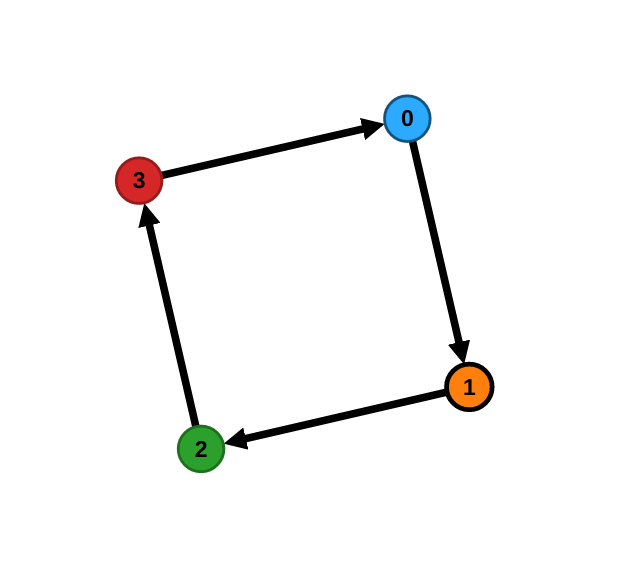

In [10]:
File.open('graph.png')

Great, so now we have our class, our directed graph (above), and a cycle in the graph (if you follow each of the pointers from _node 0_ you eventually arrive back where you started).

What we want now is to add to your class a way to start at _node 0_ and end up at _node 3_, without looping. This should work regardless of how deep the graph goes, and does not need to work for a graph where there are multiple paths heading out of one node (since our class only has one pointer).

```ruby
module Seek
    def seek
        # how would you do it?
    end
end
```

In [30]:
module Traverse
  def traverse
    original_id = self.object_id
    rec_helper = lambda do |node|
      if node.next_node && node.next_node.object_id != original_id
        rec_helper.call(node.next_node)
      else
        node
      end
    end
      rec_helper.call(self)
  end
end

:traverse

In [31]:
GraphNode.prepend(Traverse)

GraphNode